Deep Learning HW2- part 1

BY: Dema Omar , Aya Fodi



# Part 1: CNNs on CIFAR-10

In this part, we design and experiment with **Convolutional Neural Networks (CNNs)** using the **CIFAR-10** dataset.  
The goal is to understand how different architectures and parameters such as number of layers, kernel sizes, strides, and pooling methods, affect performance in image classification.

The **CIFAR-10 dataset** contains 60,000 color images (32×32 pixels) divided into 10 classes: 50,000 for training and 10,000 for testing.  
We will load the dataset using `torchvision.datasets`, split it into **training**, **validation**, and **test** sets, and display sample images.

### Tasks Overview
- **Task 1:** Build a simple CNN with 2 convolutional layers and 1 fully connected layer. Use ReLU activations, MaxPooling, and train for 10 epochs. Then visualize the feature maps of the first layer.  
- **Task 2:** Add 2 more convolutional layers (64 and 128 filters) and compare the results.  
- **Task 3:** Remove the extra layers, use 5×5 kernels and stride=2, train and compare again.  
- **Task 4:** Replace MaxPooling with AveragePooling in the best model so far and observe the effect.

Finally, compare all networks’ accuracy and performance to analyze how each architectural change impacts learning and generalization.


Load the CIFAR-10 dataset and showcase some samples from dierent classes
from the training set:

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


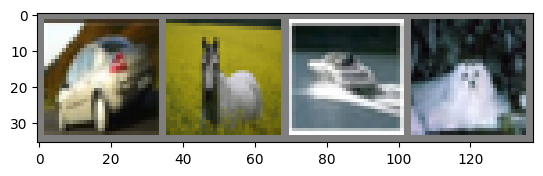

In [ ]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the input data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Splitting the training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Create data loaders to load data in batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#some samples from different classes
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images[:4]))

Task 1:
The SimpleCNN model here consists of two convolutional layers, each followed by a ReLU activation function and a max pooling layer. The first convolutional layer uses 16 filters, and the second uses 32 filters, both with a kernel size of 3x3. After processing through these layers, the image features are flattened and passed to a fully connected layer, which outputs to 10 classes. While the network directly outputs logits, the softmax function is applied during testing to convert these logits into probabilities.

Epoch 1, Train Loss: 1.488, Validation Accuracy: 57.10%
Epoch 2, Train Loss: 1.156, Validation Accuracy: 62.23%
Epoch 3, Train Loss: 1.015, Validation Accuracy: 65.25%
Epoch 4, Train Loss: 0.938, Validation Accuracy: 65.45%
Epoch 5, Train Loss: 0.879, Validation Accuracy: 67.74%
Epoch 6, Train Loss: 0.837, Validation Accuracy: 67.80%
Epoch 7, Train Loss: 0.800, Validation Accuracy: 67.96%
Epoch 8, Train Loss: 0.773, Validation Accuracy: 68.01%
Epoch 9, Train Loss: 0.747, Validation Accuracy: 68.47%
Epoch 10, Train Loss: 0.724, Validation Accuracy: 68.26%


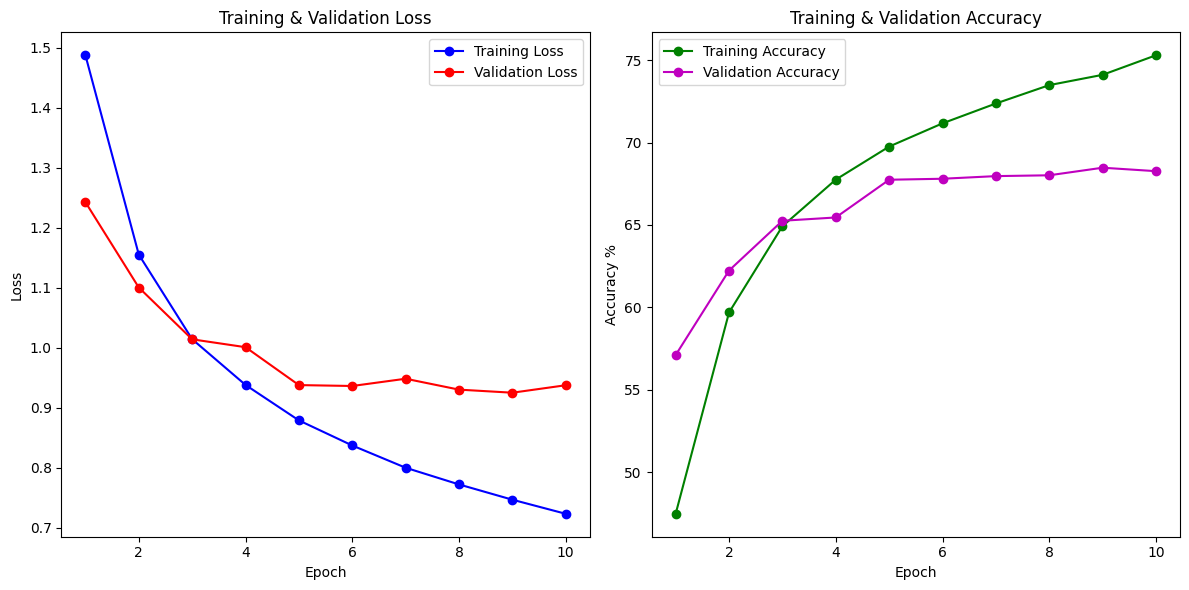

Accuracy of the model on the test images: 68.820%
Filters of the first convolutional layer after training:


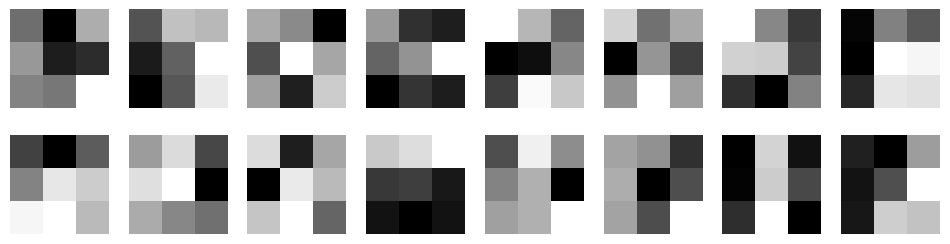

Feature maps of the first convolutional layer for a random image:


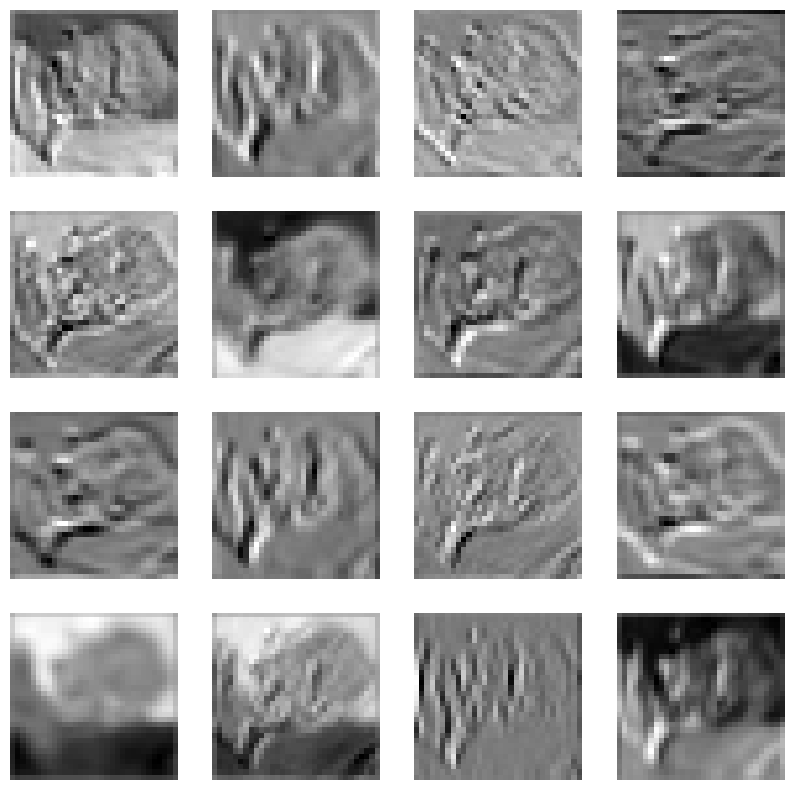

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer with a 2x2 window and a stride of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        # Apply the first and the second convolution, activation function, and then max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, validation_loader, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()  # Put the model in evaluation mode for testing
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():  # Inference mode, gradient is not computed
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = running_loss_val / len(validation_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(average_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Plot training and validation losses and accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, 'b-o', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, 'r-o', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, 'g-o', label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, 'm-o', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Test the model and return probabilities
def test_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.3f}%')

# Visualize filters of the first convolutional layer
def visualize_filters(model):
    filters = model.conv1.weight.data.cpu().numpy()
    print("Filters of the first convolutional layer after training:")
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i, ax in enumerate(axes.flatten()):
        if i < filters.shape[0]:
            ax.imshow(filters[i, 0], cmap='gray')
            ax.axis('off')
    plt.show()

# Visualize feature maps for a random test image
def visualize_feature_maps(model, test_loader):
    model.eval()
    images, _ = next(iter(test_loader))
    image = images[0].unsqueeze(0)
    with torch.no_grad():
        feature_maps = model.conv1(image).cpu()
    print("Feature maps of the first convolutional layer for a random image:")
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < feature_maps.shape[1]:
            ax.imshow(feature_maps[0, i].numpy(), cmap='gray')
            ax.axis('off')
    plt.show()

train_model(model, criterion, optimizer, train_loader, validation_loader)
probabilities = test_model(model, test_loader)
#Save the specific test image in Task 1
dataiter = iter(test_loader)
task1_image, _ = next(dataiter)
chosen_image = task1_image[0].unsqueeze(0)
torch.save(chosen_image, "task1_image.pt")  # Save the image for later use

# Visualize filters and feature maps
visualize_filters(model)
visualize_feature_maps(model, test_loader)

In [ ]:
model = SimpleCNN()
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)
Total Parameters: 25578


Task 2 : here the model starts with the same two layers as in Task 1, but includes 2 additional convolutional layers with 64 and 128 filters, with 3x3 kernel size. After sequential ReLU activation and pooling, the output is flattened and fed into a fully connected layer that classifies into 10 categories.The network produces logits which are transformed into probabilities using the softmax function during testing.





Epoch 1, Train Loss: 1.552, Validation Accuracy: 52.56%
Epoch 2, Train Loss: 1.186, Validation Accuracy: 59.17%
Epoch 3, Train Loss: 1.008, Validation Accuracy: 64.61%
Epoch 4, Train Loss: 0.887, Validation Accuracy: 67.06%
Epoch 5, Train Loss: 0.790, Validation Accuracy: 68.85%
Epoch 6, Train Loss: 0.705, Validation Accuracy: 69.83%
Epoch 7, Train Loss: 0.633, Validation Accuracy: 71.48%
Epoch 8, Train Loss: 0.564, Validation Accuracy: 72.35%
Epoch 9, Train Loss: 0.513, Validation Accuracy: 70.60%
Epoch 10, Train Loss: 0.454, Validation Accuracy: 71.71%


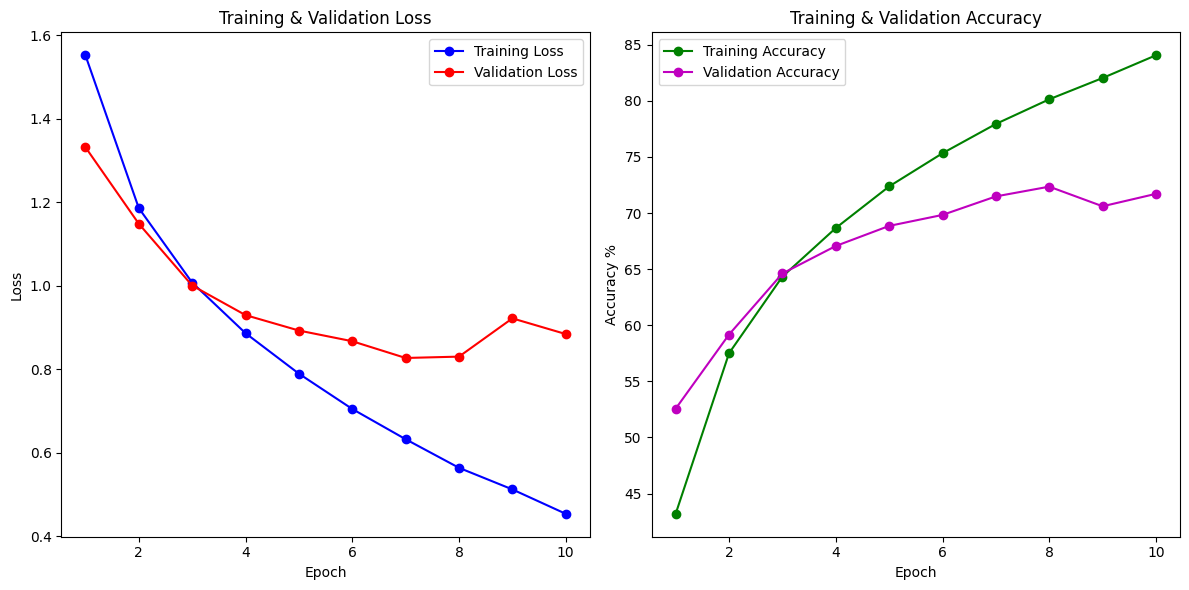

Accuracy of the model on the test images: 70.940%


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the deeper CNN architecture
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 2 * 2, 10)  # Adjusted for 4 pooling layers

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = self.fc1(x)
        return x

# Initialize the deeper model, loss function, and optimizer
deeper_model = DeeperCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deeper_model.parameters(), lr=0.001)

#Train and test the model
train_model(deeper_model, criterion, optimizer, train_loader, validation_loader)
test_model(deeper_model, test_loader)


In [ ]:
model = DeeperCNN()
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")

DeeperCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)
Total Parameters: 102570


The DeeperCNN is better than the SimpleCNN at recognizing images from the CIFAR-10 dataset. SimpleCNN has two layers and scores 69% accuracy. DeeperCNN has four layers  which helps it see more details and score higher at 72% accuracy. This makes DeeperCNN a better choice for complex images because it can pick up more details.

Task 3:
here we use larger kernel sizes and increased stride settings. It includes two convolutional layers: the first with 16 filters and the second with 32 filters, both using a 5x5 kernel size and a stride of 2, with padding adjusted to maintain dimensionality. Following the convolutional layers, a max pooling layer.Like in previous tasks, the network produces logits which are then converted into probabilities using the softmax function during testing to facilitate classification.

Epoch 1, Train Loss: 1.617, Validation Accuracy: 50.04%
Epoch 2, Train Loss: 1.315, Validation Accuracy: 55.78%
Epoch 3, Train Loss: 1.208, Validation Accuracy: 57.80%
Epoch 4, Train Loss: 1.141, Validation Accuracy: 59.30%
Epoch 5, Train Loss: 1.092, Validation Accuracy: 59.75%
Epoch 6, Train Loss: 1.055, Validation Accuracy: 60.08%
Epoch 7, Train Loss: 1.018, Validation Accuracy: 61.30%
Epoch 8, Train Loss: 0.986, Validation Accuracy: 61.30%
Epoch 9, Train Loss: 0.962, Validation Accuracy: 62.56%
Epoch 10, Train Loss: 0.937, Validation Accuracy: 60.87%


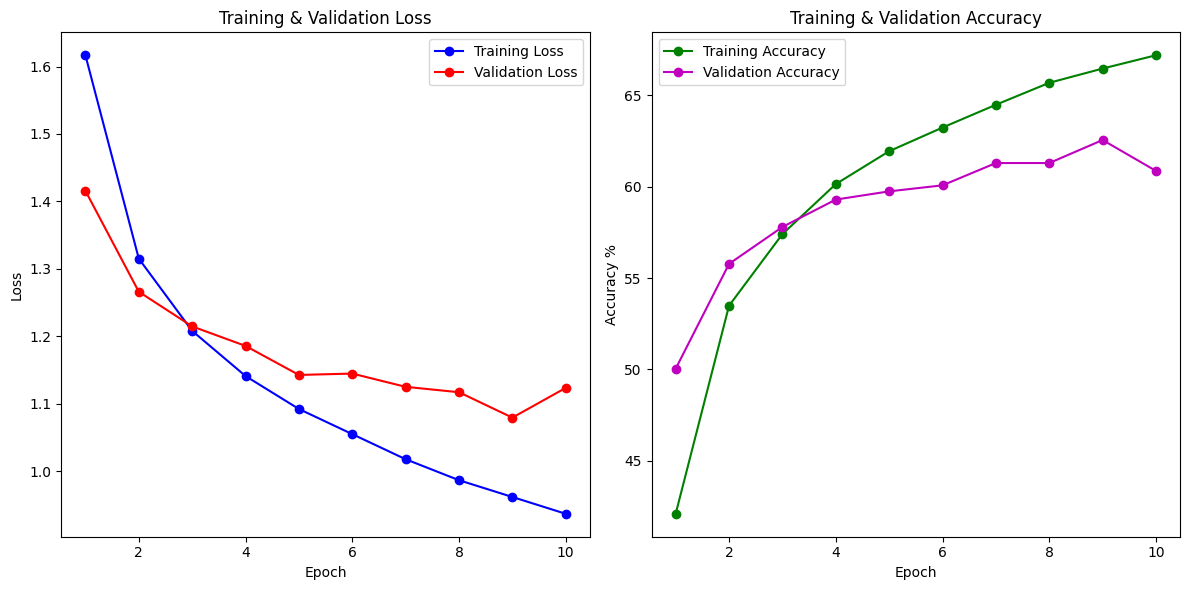

Accuracy of the model on the test images: 61.940%
Feature maps of the first convolutional layer for the specific test image:


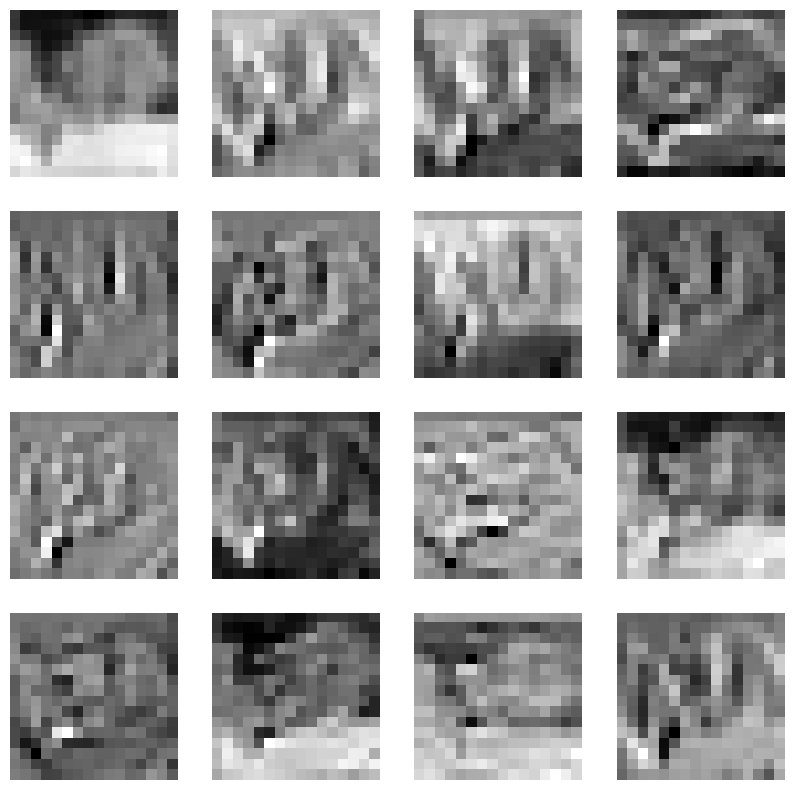

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the updated CNN architecture for Task 3
class UpdatedCNN(nn.Module):
    def __init__(self):
        super(UpdatedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 10)  # Adjusted for reduced dimensions after pooling

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = self.fc1(x)
        return x

# Initialize the updated model, loss function, and optimizer
updated_model = UpdatedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(updated_model.parameters(), lr=0.001)


# Visualize feature maps for a specific test image
def visualize_feature_maps(model, specific_image):
    model.eval()
    with torch.no_grad():
        feature_maps = model.conv1(specific_image).cpu()  # Pass the specific image through the first conv layer

    print("Feature maps of the first convolutional layer for the specific test image:")
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < feature_maps.shape[1]:
            ax.imshow(feature_maps[0, i].numpy(), cmap='gray')
            ax.axis('off')
    plt.show()

# Train, test, and visualize
train_model(updated_model, criterion, optimizer, train_loader, validation_loader)
test_model(updated_model, test_loader)

# Load the same image from Task 1
chosen_image = torch.load("task1_image.pt", weights_only=True)
visualize_feature_maps(updated_model, chosen_image)  # Visualize feature maps for the same image


In [ ]:
model = UpdatedCNN()
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")

UpdatedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)
Total Parameters: 19178


In task 3, we made the network simpler by removing layers and using larger filters. This change made the network faster but less able to notice small details, leading to a lower accuracy of 62%. Task 1's simpler network with smaller filters did better, reaching 69% accuracy. Task 2's network  which had more layers  performed the best with the highest accuracy at 72%. This shows that more layers help the network see complex images better.The changes in Task 3 made it too basic to spot the important small details needed for higher accuracy.

Task 4:here the model builds upon the best network so far (from Task 2) by replacing max pooling layers with average pooling layers. The architecture remains the same, with four convolutional layers followed by ReLU activation. The average pooling layers reduce the spatial dimensions of the feature maps, and the output is flattened and passed to a fully connected layer that classifies into 10 categories. The network is trained and tested to compare its performance with the previous models.

Epoch 1, Train Loss: 1.695, Validation Accuracy: 46.80%
Epoch 2, Train Loss: 1.390, Validation Accuracy: 51.05%
Epoch 3, Train Loss: 1.260, Validation Accuracy: 55.11%
Epoch 4, Train Loss: 1.165, Validation Accuracy: 58.52%
Epoch 5, Train Loss: 1.092, Validation Accuracy: 60.25%
Epoch 6, Train Loss: 1.028, Validation Accuracy: 63.01%
Epoch 7, Train Loss: 0.972, Validation Accuracy: 64.06%
Epoch 8, Train Loss: 0.923, Validation Accuracy: 64.21%
Epoch 9, Train Loss: 0.872, Validation Accuracy: 65.68%
Epoch 10, Train Loss: 0.826, Validation Accuracy: 67.57%


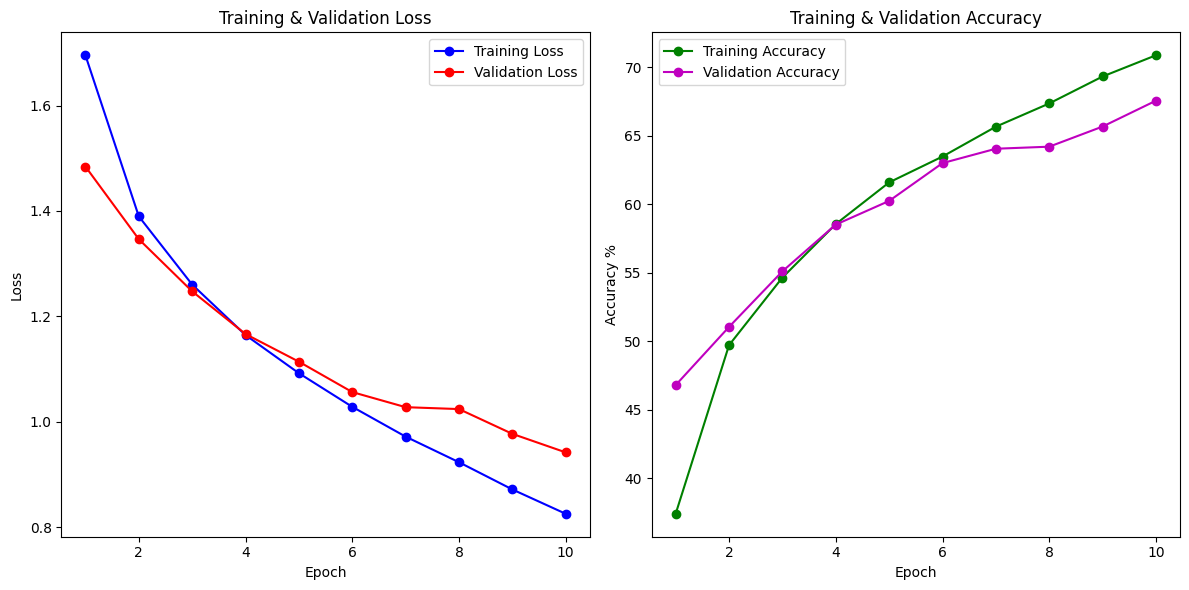

Accuracy of the model on the test images: 67.510%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the deeper CNN architecture with Average Pooling
class AveragePoolingCNN(nn.Module):
    def __init__(self):
        super(AveragePoolingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Changed MaxPool2d to AvgPool2d
        self.fc1 = nn.Linear(128 * 2 * 2, 10)  # Adjusted for 4 pooling layers

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = self.fc1(x)
        return x

# Initialize the model with Average Pooling, loss function, and optimizer
avg_pooling_model = AveragePoolingCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(avg_pooling_model.parameters(), lr=0.001)


# Train and test the model
train_model(avg_pooling_model, criterion, optimizer, train_loader, validation_loader, epochs=10)
test_model(avg_pooling_model, test_loader)

In [ ]:
model = AveragePoolingCNN()
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")

AveragePoolingCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)
Total Parameters: 102570


In both tasks 2 and 4, we use the same deep network structure but they are different in their pooling methods.in task 2  we use Max Pooling which highlights the most important features by selecting the maximum value in each region, potentially improving accuracy for complex image classification. and in task 4 we use Average Pooling, which smooths the features by averaging, possibly missing crucial details.Thus task 2 might perform better for tasks requiring detailed feature recognition .